(5712, 16384)
(1311, 16384)
(5712,)
(1311,)
Epoch: 250
Epoch: 500
Epoch: 750
Epoch: 1000
Epoch: 1250
Epoch: 1500
Epoch: 1750
Epoch: 2000
Epoch: 2250
Epoch: 2500
Epoch: 2750
Epoch: 3000
Epoch: 3250
Epoch: 3500
Epoch: 3750
Epoch: 4000


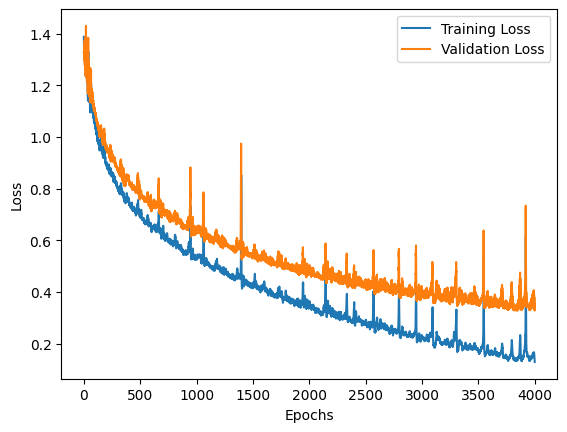

Training Accuracy: 96.78%
Validation Accuracy: 88.10%
Confusion Matrix:
[[215.  53.   6.  26.]
 [ 20. 260.   7.  19.]
 [  1.   2. 402.   0.]
 [  9.  11.   2. 278.]]

Classification Report:
Class	Precision	Recall	F1-Score
0	0.88		0.72	0.79
1	0.80		0.85	0.82
2	0.96		0.99	0.98
3	0.86		0.93	0.89

Overall Precision: 0.87
Overall Recall: 0.87
Overall F1-Score: 0.87


In [25]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import os
import sys
from layers import InputLayer, FullyConnectedLayer, ReLuLayer, SoftmaxLayer, CrossEntropy, DropoutLayer, LinearLayer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
X_train = pd.read_csv('trainingfull.csv',header=None).values
X_valid = pd.read_csv('testingfull.csv',header=None).values
Y_train = pd.read_csv('trainingfull_labels.csv',header=None).values
Y_valid = pd.read_csv('testingfull_labels.csv',header=None).values
#Y_train = np.array([Y_train])
Y_train = Y_train.flatten().astype(int)

#Y_valid = np.array([Y_valid])
Y_valid = Y_valid.flatten().astype(int)

print(np.shape(X_train))
print(np.shape(X_valid))
print(np.shape(Y_train))
print(np.shape(Y_valid))

def one_hot_encode(labels, num_classes=4):
    one_hot_encoded = np.eye(num_classes)[labels]
    return one_hot_encoded

X_train = X_train / 255.0
X_valid = X_valid / 255.0
y_train_raw = Y_train
y_valid_raw = Y_valid
y_train = one_hot_encode(y_train_raw)
y_valid = one_hot_encode(y_valid_raw)

input_layer = InputLayer(X_train)

fc_layer1 = FullyConnectedLayer(X_train.shape[1], 64)
fc_layer1.setWeights(np.random.randn(X_train.shape[1], 64) * np.sqrt(2. / X_train.shape[1]))
fc_layer1.setBiases(np.zeros((1, 64)))
relu_layer1 = ReLuLayer()

fc_layer2 = FullyConnectedLayer(64, 32)
fc_layer2.setWeights(np.random.randn(64, 32) * np.sqrt(2. / 64))
fc_layer2.setBiases(np.zeros((1, 32)))
relu_layer2 = ReLuLayer()

fc_layer3 = FullyConnectedLayer(32, 4)
fc_layer3.setWeights(np.random.randn(32,4) * np.sqrt(2. / 32))
fc_layer3.setBiases(np.zeros((1, 4)))

softmax_layer = SoftmaxLayer()
objective = CrossEntropy()
dropout1 = DropoutLayer(0.1)
dropout2 = DropoutLayer(0.1)

layers = [input_layer, fc_layer1, relu_layer1, dropout1, fc_layer2, relu_layer2, dropout2, fc_layer3, softmax_layer]

eta = 0.01
epochs = 4000

losses = []
validation_losses = []
prev_loss = float('inf')
best_val_loss = float('inf')
wait = 0
patience = 200  # You can adjust this value as needed
best_weights = {}
prev_loss = float('inf')
for epoch in range(epochs):
    if (epoch+1) % 250 == 0:
        print(f"Epoch: {epoch+1}")

    dropout1.train_mode = True
    dropout2.train_mode = True
    h = X_train
    for layer in layers:
        h = layer.forward(h)

    loss = objective.eval(y_train, h)
    losses.append(loss)

    if abs(prev_loss - loss) < 1e-7:
         break
    prev_loss = loss

    grad = objective.gradient(y_train, h)

    for layer in reversed(layers):
        newgrad = layer.backward(grad)
        if isinstance(layer, FullyConnectedLayer):
            #layer.updateWeights(grad,eta)
            dJdb = np.sum(grad, axis=0) / grad.shape[0]
            dJdW = (layer.getPrevIn().T @ grad) / grad.shape[0]
            #layer.updateWeights(grad,0.001,t=epoch+1,
                                  #       p1=0.9,p2=0.999,delta=math.pow(10,-8),
                                   #      adam=True) 
            #dJdW += 0.1 * layer.weights
            
            layer.weights -= eta * dJdW
            layer.biases -= eta * dJdb
        grad = newgrad
    # for layer in reversed(layers):
    #     newgrad = layer.backward(grad)

    #     if isinstance(layer, FullyConnectedLayer):
    #         #layer.updateWeights(grad,eta)
    #         layer.updateWeights(grad,eta,t=epoch+1,
    #                                     p1=0.9,p2=0.999,delta=math.pow(10,-8),
    #                                     adam=True) 
           
    #     grad = newgrad
    dropout1.train_mode = False
    dropout2.train_mode = False
    h_valid = X_valid
    for layer in layers:
        h_valid = layer.forward(h_valid)

    val_loss = objective.eval(y_valid, h_valid)
    validation_losses.append(val_loss)

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        # Save the weights for all layers
        for i, layer in enumerate(layers):
            if isinstance(layer, FullyConnectedLayer):
                best_weights[f'layer_{i}_weights'] = layer.weights.copy()
                best_weights[f'layer_{i}_biases'] = layer.biases.copy()
    else:
        wait += 1

    if wait >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        # Load the best weights for all layers before breaking out of the loop
        for i, layer in enumerate(layers):
            if isinstance(layer, FullyConnectedLayer):
                layer.weights = best_weights[f'layer_{i}_weights']
                layer.biases = best_weights[f'layer_{i}_biases']
        break

plt.plot(losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig("MLPLoss.png")
plt.show()
y_train_pred = np.argmax(h, axis=1)
y_valid_pred = np.argmax(h_valid, axis=1)

train_accuracy = np.mean(y_train_pred == y_train_raw)
valid_accuracy = np.mean(y_valid_pred == y_valid_raw)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {valid_accuracy * 100:.2f}%")


def confusion_matrix(true_labels, predicted_labels):
    classes = sorted(np.unique(true_labels))
    matrix = np.zeros((len(classes), len(classes)))

    for t, p in zip(true_labels, predicted_labels):
        matrix[classes.index(t), classes.index(p)] += 1
        
    return matrix

def classification_report(true_labels, predicted_labels):
    matrix = confusion_matrix(true_labels, predicted_labels)
    
    precision = np.diag(matrix) / np.sum(matrix, axis=0)
    recall = np.diag(matrix) / np.sum(matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print("Class\tPrecision\tRecall\tF1-Score")
    for i, label in enumerate(sorted(np.unique(true_labels))):
        print(f"{label}\t{precision[i]:.2f}\t\t{recall[i]:.2f}\t{f1_score[i]:.2f}")

    print("\nOverall Precision: {:.2f}".format(np.mean(precision)))
    print("Overall Recall: {:.2f}".format(np.mean(recall)))
    print("Overall F1-Score: {:.2f}".format(np.mean(f1_score)))
print("Confusion Matrix:")
print(confusion_matrix(y_valid_raw, y_valid_pred))
print("\nClassification Report:")
classification_report(y_valid_raw, y_valid_pred)